In [1]:
import numpy as np
import persim
import time
import multiprocessing as mp
from functools import partial
import math
import os

In [2]:
os.cpu_count()
pool = mp.Pool()
#https://stackoverflow.com/questions/5442910/python-multiprocessing-pool-map-for-multiple-arguments
#https://stackoverflow.com/questions/20886565/using-multiprocessing-process-with-a-maximum-number-of-simultaneous-processes

# Read in all the persistence data

In [3]:
pds = []
non_train_PATH = 'experiment_data/pd_intervals/not-trained/'#pd-model_0_ne-0.npz'
train_PATH = 'experiment_data/pd_intervals/trained/'#pd-model_0_ne-5.npz'
for i in range(50):
    non_train_pd = np.load(non_train_PATH+'pd-model_'+str(i)+'_ne-0.npz')
    pds.append(non_train_pd['pd'][0])
for i in range(50):
    train_pd = np.load(train_PATH+'pd-model_'+str(i)+'_ne-5.npz')
    pds.append(train_pd['pd'][0])

# Build up the distance matrix


In [4]:
num_networks = 100
bottle_mat = np.zeros((num_networks,num_networks))

In [5]:
N, _ = bottle_mat.shape
upper_triangle = [(i,j) for i in range(N) for j in range(i+1, N)]
#upper_triangle

In [6]:
start = time.time()
result = pool.starmap(persim.bottleneck,[(pds[i], pds[j]) for (i,j) in upper_triangle])
end = time.time()
elapsed = (end-start)/60.
print("Elapsed Time: "+str(elapsed)+" minutes." )
#Elapsed Time: 589.0427824934324 minutes.

Elapsed Time: 589.0427824934324 minutes.


In [7]:
# 1 took 0.51 minutes
# 5 parallelized took 0.94 minutes
for element in range(len(result)):
    i,j = upper_triangle[element]
    bottle_mat[i][j] = result[element]
    bottle_mat[j][i] = result[element]


In [8]:
np.savez('experiment_data/distance_matricies/bottleneck_mat',botneck=bottle_mat)

# Visualizing Distance matrix


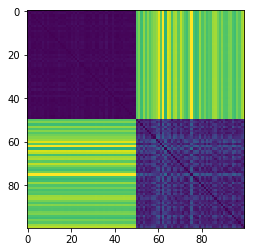

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(bottle_mat)

# Clustering our NN using the Distance Matrix

In [12]:
from sklearn.cluster import KMeans
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

In [13]:
kmeans = KMeans(n_clusters=2, random_state=423).fit(bottle_mat)

In [14]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

# Validating

In [16]:
y_true = []
for i in range(100):
    if i<50:#"not-trained":
        y_true.append(1)
    else: #"trained":
        y_true.append(0)

In [17]:
y_pred = []
for i in kmeans.labels_:
    y_pred.append(i)
#y_pred

In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
class_names = ["not-trained", "trained"]

In [21]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[50  0]
 [ 0 50]]


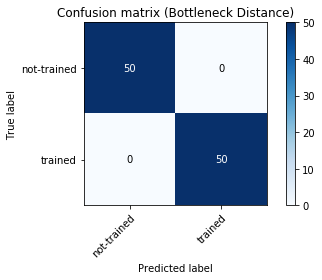

In [22]:
#Plot non-normalized confusion matrix
plot_confusion_matrix(y_true,y_pred,] classes=class_names,
                      title='Confusion matrix (Bottleneck Distance)')